In [1]:
from binascii import b2a_base64

import segmentation_models_pytorch as smp
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from tensorflow.python.ops.gen_batch_ops import batch
from torch.cuda import graph
from torch.export import export
from torch.fx.experimental.meta_tracer import torch_abs_override
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import albumentations as Album
import torch.nn.functional as Functional
import pandas as pd
import nibabel as nib
from tqdm import tqdm
from win32comext.mapi.emsabtags import PR_EMS_AB_MONITORING_ALERT_DELAY

C:\Users\sammi\anaconda3\envs\tensorflow-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_df = 'data/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
data = pd.read_csv('data/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv')

data.head(10)

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,BraTS_2020_subject_ID
0,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1,BraTS20_Training_001
1,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1,BraTS20_Training_002
2,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1,BraTS20_Training_003
3,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1,BraTS20_Training_004
4,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1,BraTS20_Training_005
5,HGG,Brats17_CBICA_ABE_1,Brats18_CBICA_ABE_1,NaN,BraTS19_CBICA_ABE_1,BraTS20_Training_006
6,HGG,Brats17_CBICA_ABM_1,Brats18_CBICA_ABM_1,NaN,BraTS19_CBICA_ABM_1,BraTS20_Training_007
7,HGG,Brats17_CBICA_ABN_1,Brats18_CBICA_ABN_1,NaN,BraTS19_CBICA_ABN_1,BraTS20_Training_008
8,HGG,Brats17_CBICA_ABO_1,Brats18_CBICA_ABO_1,NaN,BraTS19_CBICA_ABO_1,BraTS20_Training_009
9,HGG,Brats17_CBICA_ABY_1,Brats18_CBICA_ABY_1,NaN,BraTS19_CBICA_ABY_1,BraTS20_Training_010


In [3]:
root_list = []
tot_list = []

for filename_root in tqdm(np.sort(os.listdir(root_df))[:-2]):
    subpath = os.path.join(root_df, filename_root)
    file_list = []

    for filename in np.sort(os.listdir(subpath)):
        file_list.append(os.path.join(subpath, filename))

    root_list.append(filename_root)
    tot_list.append(file_list)

maps = pd.concat([
    pd.DataFrame(root_list, columns=['DIR']),
    pd.DataFrame(tot_list, columns=['flair', 'seg', 't1', 't1ce', 't2'])
    
], axis=1)

maps.to_csv('pretrained/links.csv', index=False)

100%|██████████| 369/369 [00:00<00:00, 24504.40it/s]


In [4]:
image_path = {
    'seg': [],
    't1': [],
    't1ce': [],
    't2': [],
    'flair': []
}

for path in data['BraTS_2020_subject_ID']:
    patient = os.path.join(root_df, path)

    for name in image_path:
        image_path[name].append(os.path.join(patient, path + f'_{name}.nii'))

image_path['seg'][:10]

['data/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\\BraTS20_Training_001\\BraTS20_Training_001_seg.nii',
 'data/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\\BraTS20_Training_002\\BraTS20_Training_002_seg.nii',
 'data/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\\BraTS20_Training_003\\BraTS20_Training_003_seg.nii',
 'data/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\\BraTS20_Training_004\\BraTS20_Training_004_seg.nii',
 'data/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\\BraTS20_Training_005\\BraTS20_Training_005_seg.nii',
 'data/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\\BraTS20_Training_006\\BraTS20_Training_006_seg.nii',
 'data/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\\BraTS20_Training_007\\BraTS20_Training_007_seg.nii',
 'data/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\\BraTS20_Training_008\\BraTS20_Training_008_seg.nii',
 'data/archive/BraTS2020

In [5]:
def load_image(image_path):
    return nib.load(image_path).get_fdata()


def crop_centre(image_slice, crop_x, crop_y):
    y, x = image_slice.shape

    start_x = x // 2 - (crop_x // 2)
    start_y = y // 2 - (crop_y // 2)

    return image_slice[start_y: start_y + crop_y, start_x: start_x + crop_x]


def normalize(image_slice):
    return (image_slice - image_slice.mean()) / image_slice.std()

In [6]:
def create_dataset_directories(base_dir="dataset"):
    os.makedirs(os.path.join(base_dir, "t1"), exist_ok=True)
    os.makedirs(os.path.join(base_dir, "t1ce"), exist_ok=True)
    os.makedirs(os.path.join(base_dir, "t2"), exist_ok=True)
    os.makedirs(os.path.join(base_dir, "flair"), exist_ok=True)
    os.makedirs(os.path.join(base_dir, "seg"), exist_ok=True)

In [7]:
create_dataset_directories('dataset')

In [8]:
images_saved = 0
imgs = {}
image_slice = {}

save_limit = 5000

for i in (range(len(image_path['seg']))):

    for name in image_path:
        imgs[name] = load_image(image_path[name][i])

    for j in range(155):
        for name in imgs:
            image_slice[name] = imgs[name][:, :, j]
            image_slice[name] = crop_centre(image_slice[name], 128, 128)

        if image_slice['seg'].max() > 0:
            for name in ['t1', 't2', 't1ce', 'flair']:
                image_slice[name] = normalize(image_slice[name])

            for name in image_slice:
                np.save(f'dataset/{name}/image_{images_saved}.npy', image_slice[name])

            images_saved += 1

        if images_saved == save_limit:
            break

    if images_saved == save_limit:
        break

Text(0.5, 1.0, 'T2')

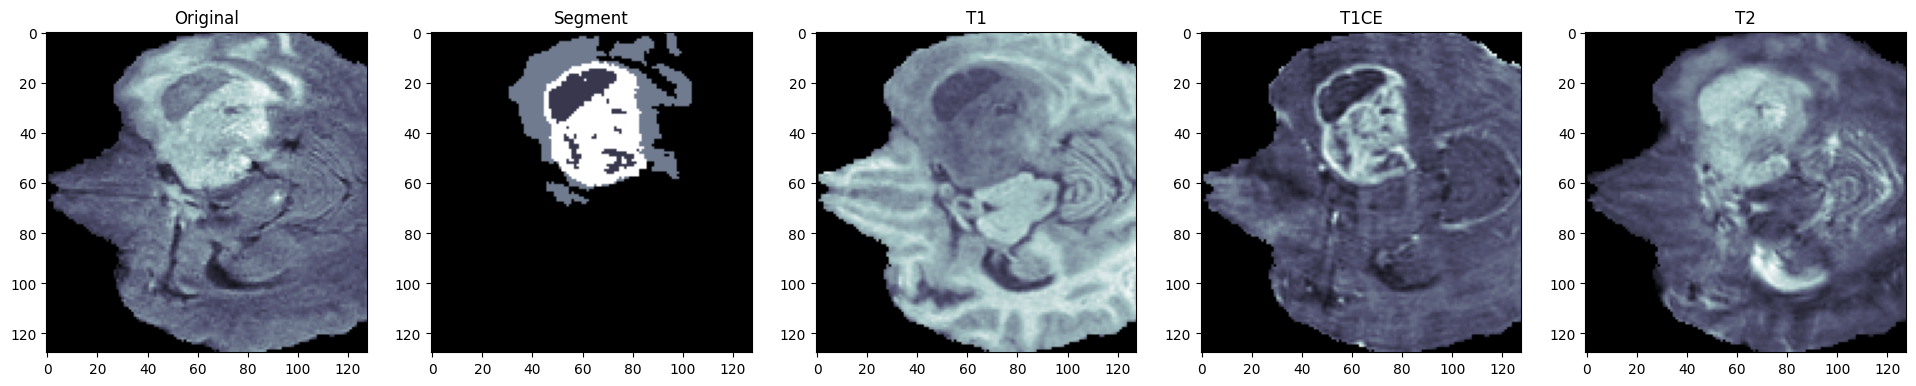

In [9]:
fig = plt.figure(figsize = (24, 15))

plt.subplot(1, 5, 1)
plt.imshow(np.load('dataset/flair/image_25.npy'), cmap='bone')
plt.title('Original')

plt.subplot(1, 5, 2)
plt.imshow(np.load('dataset/seg/image_25.npy'), cmap='bone')
plt.title('Segment')

plt.subplot(1, 5, 3)
plt.imshow(np.load('dataset/t1/image_25.npy'), cmap='bone')
plt.title('T1')

plt.subplot(1, 5, 4)
plt.imshow(np.load('dataset/t1ce/image_25.npy'), cmap='bone')
plt.title('T1CE')

plt.subplot(1, 5, 5)
plt.imshow(np.load('dataset/t2/image_25.npy'), cmap='bone')
plt.title('T2')

Text(0.5, 1.0, 'T2')

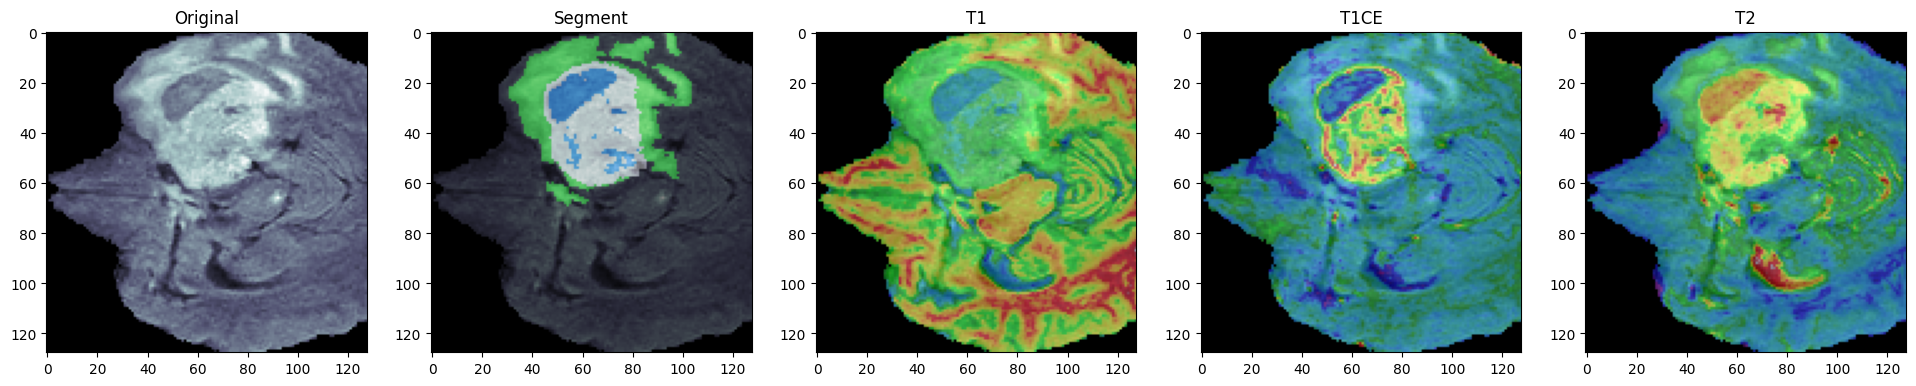

In [10]:
fig = plt.figure(figsize = (24, 15))

plt.subplot(1, 5, 1)
plt.imshow(np.load('dataset/flair/image_25.npy'), cmap = 'bone')
plt.title('Original')

plt.subplot(1, 5, 2)
plt.imshow(np.load('dataset/flair/image_25.npy'), cmap = 'bone')
plt.imshow(np.load('dataset/seg/image_25.npy'), alpha=0.5, cmap='nipy_spectral')
plt.title('Segment')

plt.subplot(1, 5, 3)
plt.imshow(np.load('dataset/flair/image_25.npy'), cmap = 'bone')
plt.imshow(np.load('dataset/t1/image_25.npy'), alpha=0.5, cmap='nipy_spectral')
plt.title('T1')

plt.subplot(1, 5, 4)
plt.imshow(np.load('dataset/flair/image_25.npy'), cmap = 'bone')
plt.imshow(np.load('dataset/t1ce/image_25.npy'), alpha=0.5, cmap='nipy_spectral')
plt.title('T1CE')

plt.subplot(1, 5, 5)
plt.imshow(np.load('dataset/flair/image_25.npy'), cmap = 'bone')
plt.imshow(np.load('dataset/t2/image_25.npy'), alpha=0.5, cmap='nipy_spectral')
plt.title('T2')

In [11]:
class DatasetGenerator(Dataset):
    def __init__(self, datapath='dataset/', augmentation=None):
        self.augmentation = augmentation

        self.folderpaths = {
            'mask': os.path.join(datapath, 'seg/'),
            't1': os.path.join(datapath, 't1/'),
            't1ce': os.path.join(datapath, 't1ce/'),
            't2': os.path.join(datapath, 't2/'),
            'flair': os.path.join(datapath, 'flair/'),
        }

    def __getitem__(self, index):
        images = {}

        for name in self.folderpaths:
            images[name] = np.load(os.path.join(self.folderpaths[name], f'image_{index}.npy')).astype(np.float32)

        # print(f"Loaded images for index {index}: {images.keys()}")

        if self.augmentation:
            augmented = self.augmentation(
                image=images['flair'],
                mask=images['mask'],
                t1=images['t1'],
                t1ce=images['t1ce'],
                t2=images['t2']
            )
            # print(f"Augmented images for index {index}: {augmented.keys()}")
            images['flair'] = augmented['image']
            images['mask'] = augmented['mask']
            images['t1'] = augmented['t1']
            images['t1ce'] = augmented['t1ce']
            images['t2'] = augmented['t2']

        for name in images:
            images[name] = torch.from_numpy(images[name])

        # STACKING UP MULTI INPUTS
        input = torch.stack([
            images['t1'],
            images['t1ce'],
            images['t2'],
            images['flair']
            
        ], dim=0)

        images['mask'][images['mask'] == 4] = 3

        # ONE-HOT TRUTH LABEL ENCODING
        images['mask'] = Functional.one_hot(
            images['mask'].long().unsqueeze(0),
            num_classes=4
        ).permute(0, 3, 1, 2).contiguous().squeeze(0)

        return input.float(), images['mask'].long()

    def __len__(self):
        return len(os.listdir(self.folderpaths['mask'])) - 1

In [12]:
augmentation = Album.Compose([
    Album.OneOf([
        Album.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        Album.GridDistortion(p=0.5),
        Album.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5)

    ], p=0.8),

    Album.RandomBrightnessContrast(p=0.8)

    ], additional_targets={
        't1': 'image',
        't1ce': 'image',
        't2': 'image'
    })

valid_test_dataset = DatasetGenerator(datapath='dataset/', augmentation=None)
train_dataset = DatasetGenerator(datapath='dataset/', augmentation=augmentation)

# USING A 4:1:1 train-validation-test
train_length = int(0.6 * len(valid_test_dataset))
valid_length = int(0.2 * len(valid_test_dataset))
test_length = len(valid_test_dataset) - train_length - valid_length

_, valid_dataset, test_dataset = torch.utils.data.random_split(
    valid_test_dataset,
    (train_length, valid_length, test_length), generator=torch.Generator().manual_seed(42)
)

train_dataset, _, _ = torch.utils.data.random_split(
    train_dataset,
    (train_length, valid_length, test_length), generator=torch.Generator().manual_seed(42)
)

In [13]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(f'* CUDA Device: {torch.cuda.get_device_name("cuda:0")}\n* Device Properties: {torch.cuda.get_device_properties("cuda:0")}')

# device = torch.cuda.device(0)
device = torch.device('cuda:0')

True
* CUDA Device: NVIDIA GeForce RTX 4070
* Device Properties: _CudaDeviceProperties(name='NVIDIA GeForce RTX 4070', major=8, minor=9, total_memory=12281MB, multi_processor_count=46, uuid=f2da3a1e-bdf3-094c-8f5b-f221eb8ef48a, L2_cache_size=36MB)


In [14]:
train_loader = DataLoader(
    train_dataset, batch_size=16,
    num_workers=0, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=1,
    num_workers=0, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size=1,
    num_workers=0, shuffle=True
)

In [15]:
a, b = next(iter(train_loader))

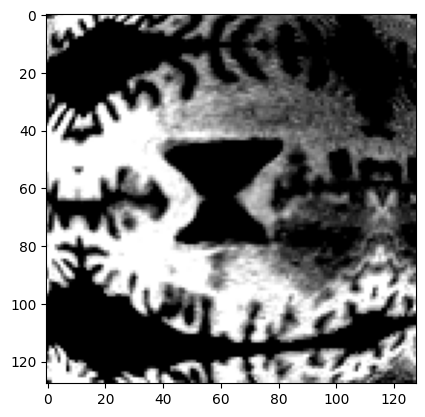

In [16]:
plt.imshow(a[0, 0], cmap='gray')

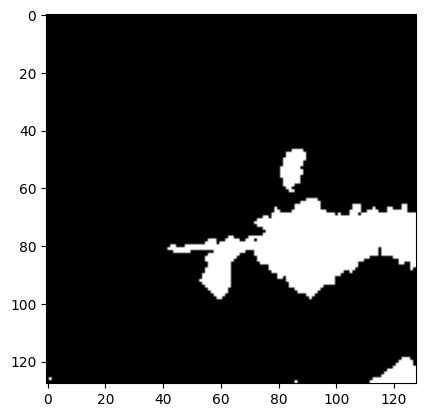

In [17]:
bb = torch.argmax(b, 0)
plt.imshow(bb[0], cmap='gray')

In [18]:
PRE_MODEL = smp.Unet(
    encoder_name='resnet50',
    encoder_depth=5,
    encoder_weights='imagenet',
    decoder_channels=[1024, 512, 256, 128, 64],
    in_channels=4,
    classes=4,
    activation=None
)

In [19]:
background_channel = [0]

dice_loss = smp.utils.losses.DiceLoss(activation='softmax2d')

optimizer = torch.optim.Adam([
    dict(params=PRE_MODEL.parameters(), lr=0.0001)
])

metrics = [
    smp.utils.metrics.IoU(threshold=0.5, ignore_channels=background_channel, activation='softmax2d'),
    smp.utils.metrics.Fscore(ignore_channels=background_channel, activation='softmax2d'),
]

In [20]:
train_epoch = smp.utils.train.TrainEpoch(
    model=PRE_MODEL, loss=dice_loss,
    metrics=[], optimizer=optimizer,
    device=device, verbose=True
)

valid_epoch = smp.utils.train.ValidEpoch(
    model=PRE_MODEL, loss=dice_loss,
    metrics=metrics, device=device,
    verbose=True
)

max_dice_score = 0

stats = {
    'train_loss' : [],
    'valid_loss' : [],
    'fscore' : [],
    'iou_score' : []
}

for i in range(200):
    print(f'\n |--- EPOCH-{i} ---| ')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    if max_dice_score < valid_logs['fscore']:
        max_dice_score = valid_logs['fscore']
        torch.save(PRE_MODEL.state_dict(), f'pretrained/model/model.pth')

        print('model saved!')

    # loss statistics
    stats['train_loss'].append(train_logs['dice_loss'])
    stats['valid_loss'].append(valid_logs['dice_loss'])

    # metric statistics
    stats['fscore'].append(valid_logs['fscore'])
    stats['iou_score'].append(valid_logs['iou_score'])

    np.save(f'pretrained/model/model.npy', stats)


 |--- EPOCH-0 ---| 
valid: 100%|██████████| 999/999 [00:09<00:00, 100.73it/s, dice_loss - 0.0497, iou_score - 0.2891, fscore - 0.379]  
model saved!

 |--- EPOCH-1 ---| 
valid: 100%|██████████| 999/999 [00:08<00:00, 113.10it/s, dice_loss - 0.02942, iou_score - 0.4762, fscore - 0.5826]
model saved!

 |--- EPOCH-2 ---| 
valid: 100%|██████████| 999/999 [00:08<00:00, 114.46it/s, dice_loss - 0.02747, iou_score - 0.4778, fscore - 0.5816]

 |--- EPOCH-3 ---| 
valid: 100%|██████████| 999/999 [00:08<00:00, 113.51it/s, dice_loss - 0.02129, iou_score - 0.543, fscore - 0.6415] 
model saved!

 |--- EPOCH-4 ---| 
valid: 100%|██████████| 999/999 [00:08<00:00, 111.63it/s, dice_loss - 0.02073, iou_score - 0.5356, fscore - 0.63]  

 |--- EPOCH-5 ---| 
valid: 100%|██████████| 999/999 [00:08<00:00, 114.33it/s, dice_loss - 0.0198, iou_score - 0.5736, fscore - 0.6741] 
model saved!

 |--- EPOCH-6 ---| 
valid: 100%|██████████| 999/999 [00:08<00:00, 114.79it/s, dice_loss - 0.018, iou_score - 0.5771, fscore -

Text(0.5, 1.0, 'TRAIN & VALIDATION LOSS')

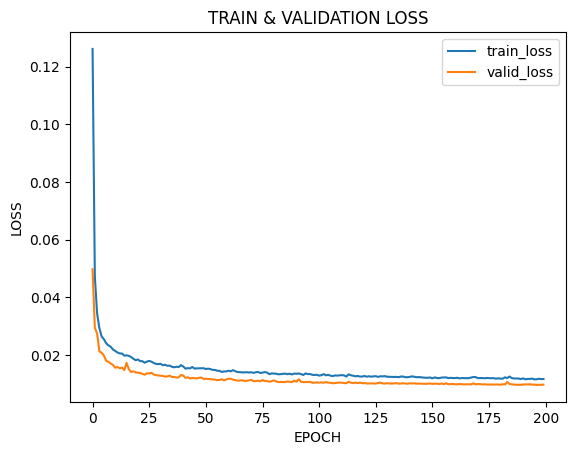

In [22]:
stats = np.load(f'pretrained/model/model.npy', allow_pickle=True).item()
plt.plot(stats['train_loss'], label='train_loss')
plt.plot(stats['valid_loss'], label='valid_loss')

plt.legend(loc='upper right')

plt.xlabel('EPOCH')
plt.ylabel('LOSS')

plt.title('TRAIN & VALIDATION LOSS')

Text(0.5, 1.0, 'IOU_SCORE')

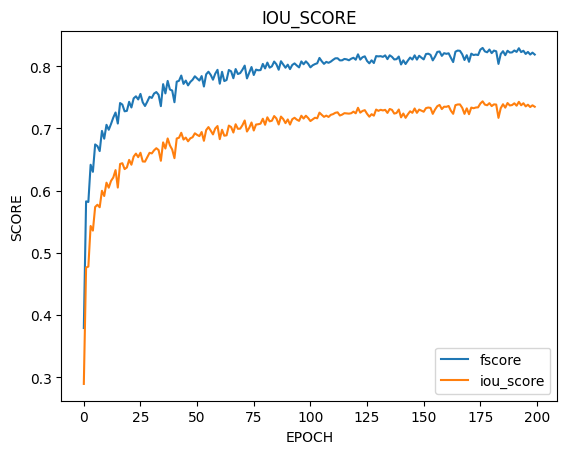

In [30]:
STATS = np.load(f'pretrained/model/model.npy', allow_pickle=True).item()
plt.plot(STATS['fscore'], label = 'fscore')
plt.legend(loc = "lower right")
plt.ylabel('score')
plt.xlabel('epoch')
plt.title('Fscore')

plt.plot(STATS['iou_score'], label ='iou_score')
plt.legend(loc = "lower right")
plt.ylabel('SCORE')
plt.xlabel('EPOCH')
plt.title('IOU_SCORE')

In [24]:
PRE_MODEL.load_state_dict(torch.load('pretrained/model/model.pth', weights_only=True))

<All keys matched successfully>

In [25]:
prediction = PRE_MODEL(a.cuda())

Text(0.5, 1.0, 'Prediction')

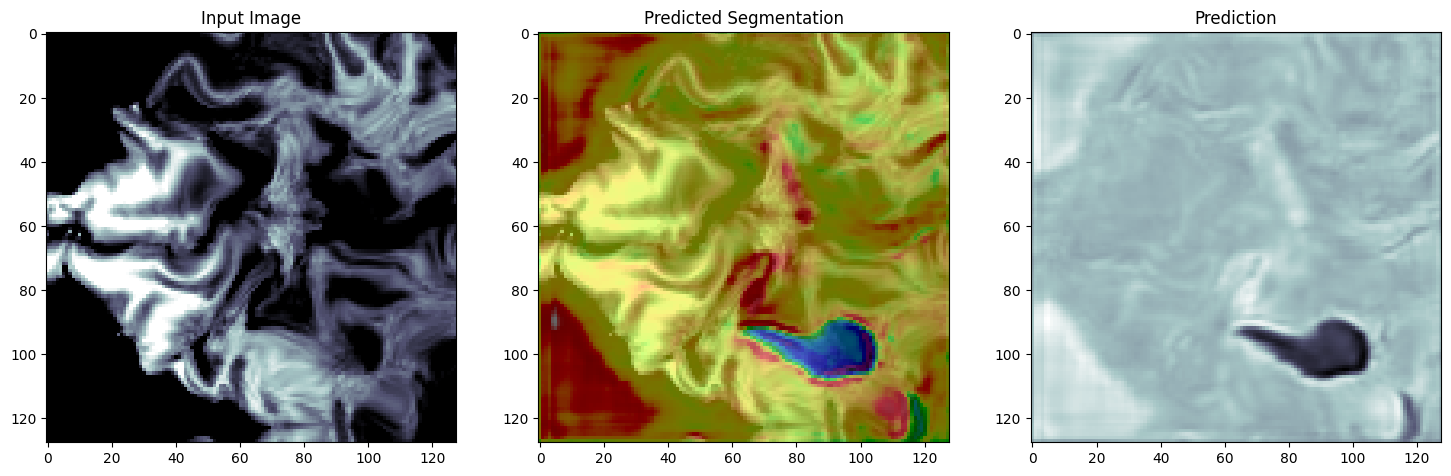

In [26]:
plt.figure(figsize = (18, 10))
plt.subplot(1, 3, 1)
plt.imshow(a[2, 0],cmap='bone')
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(a[2, 0],cmap='bone')
plt.imshow(prediction.cpu().detach()[2, 0], alpha=0.5, cmap='nipy_spectral')
plt.title('Predicted Segmentation')

plt.subplot(1, 3, 3)
plt.imshow(prediction.cpu().detach()[2, 0], cmap='bone')
plt.title('Prediction')

In [27]:
class WrappedModel(nn.Module):
    def __init__(self, model):
        super(WrappedModel, self).__init__()
        self.model = model
        self.add_module('model', model)  # Register the model as a submodule

    def forward(self, x):
        return self.model(x)

In [28]:
import hiddenlayer as h_layer

wrapped_model = WrappedModel(PRE_MODEL)

batch = next(iter(train_loader))
transforms = [h_layer.transforms.Prune('Constant')]

# Trace the wrapped model
traced_model = torch.jit.trace(wrapped_model, batch[0].cuda())

# Build the graph
graph = h_layer.build_graph(traced_model, batch[0].cuda(), transforms=transforms)
graph.theme = h_layer.graph.THEMES['blue'].copy()
graph.save('rnn_hiddenlayer', format='png')

RuntimeError: Tried to trace <__torch__.WrappedModel object at 00000080F430FFD0> but it is not part of the active trace. Modules that are called during a trace must be registered as submodules of the thing being traced.

In [29]:
print(PRE_MODEL)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      